# Step 1. Preprocessing

## 1.1. Import packages and MNIST dataset

In [1]:
import random

import tensorflow as tf
import numpy as np

import sklearn
from sklearn.decomposition import PCA

from keras.datasets import mnist
from matplotlib import pyplot
from mpl_toolkits import mplot3d

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

Now, we display some examples from the MNIST dataset

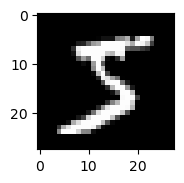

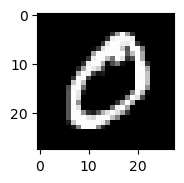

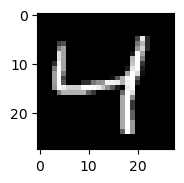

In [3]:
for i in range(3):  
    pyplot.figure(figsize=(6, 2))
    pyplot.subplot(1, 3, 1+i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

Here we set the hyperparameters:
- $\alpha$ is a parameter in a _LeakyReLU_ layer $\phi_{\alpha}(x) = \begin{cases} x,&x \geq 0\\ \alpha x,& x < 0 \end{cases}$
- $\theta$ is a margin parameter in a triplet loss

Other parameters are self-explanatory

In [5]:
EMBEDDING_SIZE = 10

hyperparams = {
    'input_shape': (28,28),
    'hidden_layer_size': 2048,
    'batch_size': 1028,
    'epochs': 100,
    'alpha': 0.01,
    'regulizer': 1e-3,
    'theta': 0.2,
    'epsilon': 1e-8,
    'learning_rate': 5e-5
}

## 1.2. Form triplets

Here, we form triplets in a form $(A,P,N)$ where $A$ and $P$ are the same digits while $N$ is a different one.

However, not all triplets are actually useful during the training phase. Therefore, our algorithm for forming triplets is following:
- Choose two digits $a$ and $b$ ($a,b \in \{0,\dots,9\}$)
- Choose $n_B$ triplets $\{A_j,P_j,N_j\}_{j=1}^{n_B}$ in which $A$ and $P$ correspond to digit $a$ while $N$ to a digit $b$.
- Sort these triplets according to loss $\mathcal{L}(A,P,N) = \|\mathcal{E}(A)-\mathcal{E}(P)\|_2^2 - \|\mathcal{E}(A)-\mathcal{E}(N)\|_2^2$ where $\mathcal{E}: \mathbb{R}^{28\times 28} \to \mathcal{S}_{\mathbb{R}^{10}}$ is our embedding model we want to learn
- Pick $\frac{n_B}{2}$ triplets from the middle

In [6]:
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, X: list, y: list, batch_size: int, embedding_model: any) -> None:
        """
        Initializes triplets generator
        """
        
        self._n = len(X)
        assert self._n == len(y), "The number of images and labels is the same"
        
        self._X = X
        self._y = y
        self._batch_size = batch_size
        self._hard_size = batch_size//2
        self._model = embedding_model
        
        self._unique_labels = np.unique(y)
        self._X_batches = {}
        for y_unique in self._unique_labels:
            batch = [X[i] for i in range(self._n) if y[i] == y_unique]
            self._X_batches[y_unique] = batch
            assert len(batch) >= 2*batch_size, 'Each batch with the same label must contain at least 2*batch_size of images'
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        
        np.random.shuffle(self._unique_labels)
    
    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return self._n // self._batch_size
    
    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        
        np.random.shuffle(self._unique_labels)
        positive_index, negative_index = self._unique_labels[:2]
        
        positive_images = self._X_batches[positive_index][:2*self._batch_size]
        negative_images = self._X_batches[negative_index][:self._batch_size]
        
        np.random.shuffle(positive_images)
        np.random.shuffle(negative_images)
        
        anchors = np.array([positive_images[2*i] for i in range(self._batch_size)])
        positives = np.array([positive_images[2*i+1] for i in range(self._batch_size)])
        negatives = np.array([negative_images[i] for i in range(self._batch_size)])
        
        # Picking the hardest triplets
        anchor_embeddings = self._model.predict(anchors, verbose=0)
        positive_embeddings = self._model.predict(positives, verbose=0)
        negative_embeddings = self._model.predict(negatives, verbose=0)
        
        ap_distances = np.sum(np.square(anchor_embeddings - positive_embeddings), axis=1)
        an_distances = np.sum(np.square(anchor_embeddings - negative_embeddings), axis=1)
        
        losses = ap_distances - an_distances
        triplets = [(anchors[i], positives[i], negatives[i]) for i in range(self._batch_size)]
        sorted_zip = sorted(zip(losses, triplets), key=lambda x: x[0])
        sorted_triplets = [triplet for _, triplet in sorted_zip]
        sorted_triplets = sorted_triplets[self._hard_size//2:3*self._hard_size//2]
        
        # Unpacking sorted triplets
        
        hard_anchors, hard_positives, hard_negatives = [], [], []
        for triplet in sorted_triplets:
            hard_anchors.append(triplet[0])
            hard_positives.append(triplet[1])
            hard_negatives.append(triplet[2])
            
        hard_anchors, hard_positives, hard_negatives = np.array(hard_anchors), np.array(hard_positives), np.array(hard_negatives)
        return [hard_anchors, hard_positives, hard_negatives], np.ones((self._batch_size, 3*EMBEDDING_SIZE))

# 2. Training the Siamese Neural Network

We build an embedding model consisting of two dense layers and a unit normalization at the end. Then, we stack the same embedding model three times in a Siamese Neural Network. We then train the model to minimize
$$
\mathcal{L} = \frac{1}{|\mathcal{B}|}\sum_{A,P,N \in \mathcal{B}} \text{ReLU}\left(\|\mathcal{E}(A)-\mathcal{E}(P)\|_2^2-\|\mathcal{E}(A)-\mathcal{E}(N)\|_2^2+\theta\right)
$$

In [7]:
def EmbeddingModel(hyperparams: dict):
    """
    Embedding model is a target model that we need to train to make predictions.
    """
    
    embedding_model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=hyperparams['input_shape']),
        tf.keras.layers.Dense(
            hyperparams['hidden_layer_size'],
            name='hidden_layer',
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(hyperparams['regulizer'])),
        tf.keras.layers.LeakyReLU(alpha=hyperparams['alpha']),
        tf.keras.layers.Dense(
            EMBEDDING_SIZE,  
            name="output_layer",
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=tf.keras.regularizers.l2(hyperparams['regulizer']),
            activation=None
        ),
        tf.keras.layers.UnitNormalization(axis=1)
    ])
    
    embedding_model.summary()
    return embedding_model

def SNN(embedding_model, hyperparams):
    """
    Siamese neural network is used for training Embedding model and uses three inputs: 
    anchor, positive, and negative 
    
    Input:
    embedding_model - embedding model generated by the function above
    
    Output:
    Siamese Neural Network and summary() output
    """
    
    input_anchor = tf.keras.layers.Input(shape=hyperparams['input_shape'])
    input_positive = tf.keras.layers.Input(shape=hyperparams['input_shape'])
    input_negative = tf.keras.layers.Input(shape=hyperparams['input_shape'])

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = tf.keras.layers.concatenate(
        [embedding_anchor, 
         embedding_positive, 
         embedding_negative], axis=1)
    
    siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
    siamese_net.summary()
    
    return siamese_net

In [8]:
embedding_model = EmbeddingModel(hyperparams)
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 2048)              1607680   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
 unit_normalization (UnitNor  (None, 10)               0         
 malization)                                                     
                                                                 
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
______________________________________________

In [9]:
snn = SNN(embedding_model, hyperparams)
snn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential (Sequential)        (None, 10)           1628170     ['input_1[0][0]',                
                                                                  'input_2[0][0]',            

In [10]:
def triplet_distance_loss(y_true, y_predicted):
    anchor = y_predicted[:,:EMBEDDING_SIZE]
    positive = y_predicted[:,EMBEDDING_SIZE:(2*EMBEDDING_SIZE)]
    negative = y_predicted[:,(2*EMBEDDING_SIZE):]
    
    positive_distances = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_distances = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    
    return tf.maximum(positive_distances - negative_distances + hyperparams['theta'], 
                      hyperparams['epsilon'])

In [11]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=hyperparams['learning_rate'])
snn.compile(loss=triplet_distance_loss, optimizer=optimizer)

2023-10-22 16:38:51.207328: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2023-10-22 16:38:51.475827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - ETA: 0s - loss: 4.1756

2023-10-22 16:39:04.865591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - 14s 240ms/step - loss: 4.1756 - val_loss: 4.0961
Epoch 2/50
58/58 [==============================] - 15s 261ms/step - loss: 3.9993 - val_loss: 3.8931
Epoch 3/50
58/58 [==============================] - 22s 377ms/step - loss: 3.8542 - val_loss: 3.7743
Epoch 4/50
58/58 [==============================] - 15s 252ms/step - loss: 3.7078 - val_loss: 3.6582
Epoch 5/50
58/58 [==============================] - 13s 215ms/step - loss: 3.5723 - val_loss: 3.4573
Epoch 6/50
58/58 [==============================] - 16s 272ms/step - loss: 3.4307 - val_loss: 3.3730
Epoch 7/50
58/58 [==============================] - 21s 367ms/step - loss: 3.3075 - val_loss: 3.2845
Epoch 8/50
58/58 [==============================] - 20s 347ms/step - loss: 3.1857 - val_loss: 3.1227
Epoch 9/50
58/58 [==============================] - 14s 246ms/step - loss: 3.0548 - val_loss: 3.0091
Epoch 10/50
58/58 [==============================] - 14s 235ms/step - loss: 2.9464 - val_loss: 2.8882


In [19]:
generator_train = TripletGenerator(
    X_train, 
    y_train, 
    batch_size=hyperparams['batch_size'], 
    embedding_model=embedding_model
)
generator_validate = TripletGenerator(
    X_test, 
    y_test, 
    batch_size=128, 
    embedding_model=embedding_model
)

history = snn.fit(
    generator_train,
    epochs=hyperparams['epochs'],
    verbose=1,
    validation_data = generator_validate,
    validation_steps=len(y_test) // hyperparams['batch_size']
)

Epoch 1/50


2023-10-22 16:57:10.980627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - ETA: 0s - loss: 0.8322

2023-10-22 16:57:25.027813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


58/58 [==============================] - 15s 250ms/step - loss: 0.8322 - val_loss: 0.8408
Epoch 2/50
58/58 [==============================] - 16s 267ms/step - loss: 0.8113 - val_loss: 0.8082
Epoch 3/50
58/58 [==============================] - 21s 355ms/step - loss: 0.7901 - val_loss: 0.7720
Epoch 4/50
58/58 [==============================] - 18s 306ms/step - loss: 0.7787 - val_loss: 0.7689
Epoch 5/50
58/58 [==============================] - 16s 271ms/step - loss: 0.7635 - val_loss: 0.7535
Epoch 6/50
58/58 [==============================] - 16s 272ms/step - loss: 0.7465 - val_loss: 0.7651
Epoch 7/50
58/58 [==============================] - 18s 303ms/step - loss: 0.7364 - val_loss: 0.7142
Epoch 8/50
58/58 [==============================] - 14s 246ms/step - loss: 0.7329 - val_loss: 0.7143
Epoch 9/50
58/58 [==============================] - 17s 285ms/step - loss: 0.7174 - val_loss: 0.7087
Epoch 10/50
58/58 [==============================] - 14s 234ms/step - loss: 0.6974 - val_loss: 0.7017


## 3. Checking embedding model results

In [20]:
predictions_number = 15
predictions = embedding_model.predict(X_test[:predictions_number])

for (label, prediction) in sorted(zip(y_test[:predictions_number], predictions), key=lambda x: x[0]):
    print(f'{label}: {prediction[:5]}')

1/1 [==============================] - 0s 33ms/step
0: [-0.46429336  0.1469808   0.3556157   0.62593603  0.04549672]
0: [-0.4984211   0.1339177   0.15096825  0.70186615  0.04643202]
0: [-0.51166517  0.05046197  0.2837872   0.67156917  0.11530824]
1: [ 0.02577561 -0.08717237  0.69025004 -0.03745135  0.3323654 ]
1: [ 0.01778442 -0.19232689  0.6968142  -0.06762763  0.28678045]
1: [ 0.01908576 -0.13260418  0.5831398  -0.09791678  0.2784453 ]
2: [-0.09577143  0.19528826 -0.43540716  0.07860273  0.05697103]
4: [ 0.01381726 -0.55913305 -0.09063645 -0.40995663  0.27489617]
4: [-0.23982015 -0.52264756 -0.04441823 -0.33628651  0.20432763]
5: [-0.05168714 -0.1233023  -0.6850585  -0.2861398   0.24085082]
6: [-0.42686588  0.52222204  0.13002852  0.0637344   0.38812074]
7: [ 0.65262187  0.16466844  0.37731075  0.25409368 -0.39314824]
9: [ 0.4246936  -0.47598705 -0.09099863 -0.29542983  0.10450802]
9: [ 0.39901936 -0.28211248  0.17683595 -0.23956475  0.11402157]
9: [ 0.38189194 -0.42829096  0.0543480

In [23]:
predict_pca = embedding_model.predict(X_train[:5000])

predictions_batches, colors = [], []
for i in range(10):
    predictions_batch = [prediction for prediction, y in zip(predict_pca, y_train) if i == y]
    predictions_batches.append(predictions_batch)
    colors.append([i] * len(predictions_batch))

flattenned_predictions = [item for batch in predictions_batches for item in batch]
flattenned_colors = [item for batch in colors for item in batch]

157/157 [==============================] - 0s 2ms/step


/var/folders/v0/zz8w2jg50k15rrlj48nht3l00000gn/T/ipykernel_9890/3991633965.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], c=colors[i], label=f'Number {i}', cmap='jet')
/var/folders/v0/zz8w2jg50k15rrlj48nht3l00000gn/T/ipykernel_9890/3991633965.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], c=colors[9], label=f'Number 9', cmap='jet')


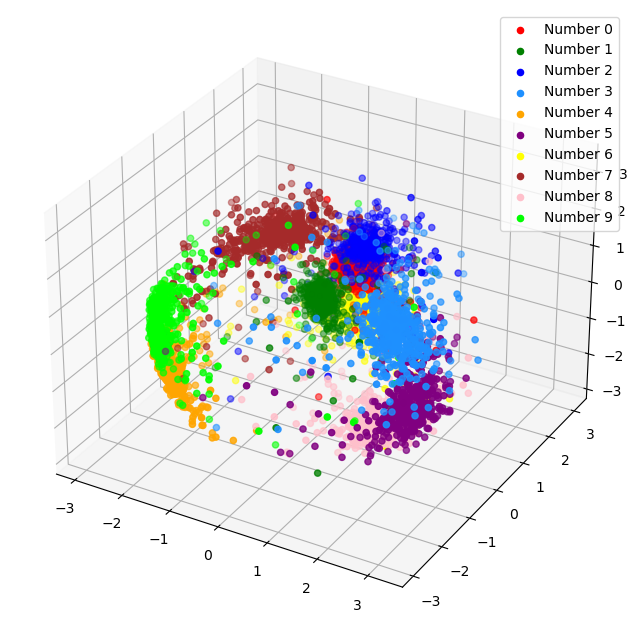

In [26]:
# Launching PCA
pca = PCA(n_components=3)
pca = sklearn.decomposition.PCA(n_components=3)
batch_scaled = sklearn.preprocessing.StandardScaler().fit_transform(flattenned_predictions)
pca_features = pca.fit_transform(batch_scaled)

# Getting scaled features
x_data = pca_features[:,0]
y_data = pca_features[:,1]
z_data = pca_features[:,2]
 
# Plot 3D plot
pyplot.style.use('default')
fig = pyplot.figure(figsize=(10,8))
ax = pyplot.axes(projection='3d')

from_n, to_n = 0, len(predictions_batches[0])
colors = ['r', 'g', 'b', 'dodgerblue', 'orange', 'purple', 'yellow', 'brown', 'pink', 'lime']

for i in range(len(predictions_batches)-1):
    ax.scatter3D(x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], c=colors[i], label=f'Number {i}', cmap='jet')
    from_n = to_n
    to_n = to_n + len(predictions_batches[i+1])

ax.scatter3D(x_data[from_n:to_n], y_data[from_n:to_n], z_data[from_n:to_n], c=colors[9], label=f'Number 9', cmap='jet')
ax.legend()
pyplot.show()

In [27]:
embedding_model.save('embedding_v1')

INFO:tensorflow:Assets written to: embedding_v1/assets
